In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn optuna shap fastapi streamlit joblib

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### 📊 Step 1: Load and Prepare Dataset

- Import necessary libraries for data handling, visualization, and modeling.
- Load the Indian food nutrition dataset from CSV.
- Print the shape and column names of the dataset.
- Rename long or complex column names to shorter, more convenient labels.
- Display the first few rows of the cleaned dataset to verify changes.


In [2]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [3]:
df = pd.read_csv("../dataset/Indian_Food_Nutrition_Processed.csv")
print("Shape of dataset:",df.shape)
print("Columns:",df.columns)
display(df.head())

Shape of dataset: (1014, 12)
Columns: Index(['Dish Name', 'Calories (kcal)', 'Carbohydrates (g)', 'Protein (g)',
       'Fats (g)', 'Free Sugar (g)', 'Fibre (g)', 'Sodium (mg)',
       'Calcium (mg)', 'Iron (mg)', 'Vitamin C (mg)', 'Folate (µg)'],
      dtype='object')


,Dish Name,Calories (kcal),Carbohydrates (g),Protein (g),Fats (g),Free Sugar (g),Fibre (g),Sodium (mg),Calcium (mg),Iron (mg),Vitamin C (mg),Folate (µg)
0,Hot tea (Garam Chai),16.14,2.58,0.39,0.53,2.58,0.00,3.12,14.20,0.02,0.50,1.80
1,Instant coffee,23.16,3.65,0.64,0.75,3.62,0.00,4.92,20.87,0.06,1.51,5.60
2,Espreso coffee,51.54,6.62,1.75,2.14,6.53,0.00,13.98,58.10,0.15,1.51,5.53
3,Iced tea,10.34,2.70,0.03,0.01,2.70,0.00,0.23,1.18,0.02,5.95,1.28
4,Raw mango drink (Aam panna),35.92,9.05,0.16,0.03,7.49,0.61,79.82,7.08,0.14,45.30,14.05


In [4]:
df.columns

Index(['Dish Name', 'Calories (kcal)', 'Carbohydrates (g)', 'Protein (g)',
       'Fats (g)', 'Free Sugar (g)', 'Fibre (g)', 'Sodium (mg)',
       'Calcium (mg)', 'Iron (mg)', 'Vitamin C (mg)', 'Folate (µg)'],
      dtype='object')

In [5]:
df.rename(columns={
    'Dish Name': 'dish',
    'Calories (kcal)': 'calories',
    'Carbohydrates (g)': 'carbs',
    'Protein (g)': 'protein',
    'Fats (g)': 'fat',
    'Free Sugar (g)': 'sugar',
    'Fibre (g)': 'fiber',
    'Sodium (mg)': 'sodium',
    'Calcium (mg)': 'calcium',
    'Iron (mg)': 'iron',
    'Vitamin C (mg)': 'vitamin_c',
    'Folate (µg)': 'folate'
}, inplace=True)

print("Columns after renaming:", df.columns.tolist())


Columns after renaming: ['dish', 'calories', 'carbs', 'protein', 'fat', 'sugar', 'fiber', 'sodium', 'calcium', 'iron', 'vitamin_c', 'folate']


### 🧹 Step 2: Handle Duplicates and Missing Values

- Check for and remove duplicate rows to ensure data quality.
- Identify missing values in the dataset.
- Handle missing values using domain knowledge:
  - **Macronutrients** (like calories, protein, fat, carbs): imputed with **median** values.
  - **Micronutrients and vitamins** (like fiber, sugar, sodium, etc.): imputed with **0**, assuming absence.
- Print the number of unique values in each column to understand the variability in the data.


In [7]:
print("\nDuplicate rows before:", df.duplicated().sum())


Duplicate rows before: 0


In [8]:
df = df.drop_duplicates()
print("Duplicate rows after:", df.duplicated().sum())

Duplicate rows after: 0


In [9]:
df.isnull().sum()

dish          0
calories      0
carbs         0
protein       0
fat           0
sugar         0
fiber         0
sodium        0
calcium       0
iron          0
vitamin_c    82
folate       82
dtype: int64

In [10]:
#  Handle Missing Values using Domain Knowledge:
# - Macros: median imputation
# - Micronutrients & vitamins: 0 imputation

In [11]:
macro_cols = ['calories', 'protein', 'fat', 'carbs']
zero_cols = ['sugar', 'fiber', 'sodium', 'calcium', 'iron', 'vitamin_c', 'folate']


In [12]:
for col in macro_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

In [13]:
for col in zero_cols:
    df[col] = df[col].fillna(0)

In [14]:
df.isnull().sum()

dish         0
calories     0
carbs        0
protein      0
fat          0
sugar        0
fiber        0
sodium       0
calcium      0
iron         0
vitamin_c    0
folate       0
dtype: int64

In [15]:
print("Unique values per column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()}")

Unique values per column:
dish: 1014
calories: 996
carbs: 877
protein: 631
fat: 828
sugar: 681
fiber: 417
sodium: 985
calcium: 968
iron: 272
vitamin_c: 649
folate: 864


In [16]:
df["dish"].unique()

array(['Hot tea (Garam Chai)', 'Instant coffee', 'Espreso coffee', ...,
       'Tomato chutney (Tamatar ki chutney)', 'Tomato ketchup',
       'Bengal 5 Spice Blend (Panch Phoran)'], shape=(1014,), dtype=object)

In [17]:
numeric_cols = macro_cols + zero_cols
print("\nNumeric Columns:", numeric_cols)


Numeric Columns: ['calories', 'protein', 'fat', 'carbs', 'sugar', 'fiber', 'sodium', 'calcium', 'iron', 'vitamin_c', 'folate']


In [18]:
for col in numeric_cols:
    if not np.issubdtype(df[col].dtype, np.number):
        print(f"⚠ Column {col} has non-numeric values!")

### 🧪 Step 3: Describe and Cap Extreme Nutritional Values

- Use `.describe()` to get a statistical overview of the dataset.
- Identify and cap **extreme or unrealistic values** based on domain knowledge:
  - **Sodium** > 5000 mg is too high for a typical dish.
  - **Fiber** > 25 g is unrealistic for most cooked foods.
  - **Vitamin C** > 250 mg is extremely rare, even in juices.
- Apply **capping** instead of removal to preserve the importance of each dish.
- After capping, check the maximum values in affected columns to confirm.


In [19]:
df.describe()

,calories,carbs,protein,fat,sugar,fiber,sodium,calcium,iron,vitamin_c,folate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,233.735897,18.354004,4.753008,16.267584,8.824832,1.962485,481.076755,59.877091,1.136953,13.773353,38.530020
std,187.599467,16.745936,3.442746,20.452322,12.378324,2.771622,1750.646423,67.441463,1.520863,25.845012,53.154148
min,6.610000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,101.180000,5.582500,2.100000,4.030000,1.152500,0.590000,41.910000,18.237500,0.460000,0.412500,9.252500
50%,174.920000,11.925000,3.990000,9.095000,2.780000,1.325000,101.290000,40.680000,0.830000,4.625000,21.955000
75%,315.845000,26.870000,6.602500,17.085000,11.822500,2.347500,196.605000,79.385000,1.290000,16.667500,45.437500
max,839.330000,86.530000,21.550000,90.450000,85.570000,35.710000,14174.590000,631.820000,20.570000,382.640000,550.520000


Remove only extreme unrealistic values:

sodium > 5000 mg (5 g salt for 100g dish is too much).

fiber > 25 g (unrealistic for cooked food).

vitamin_c > 250 mg (except juices, but still extreme).

In [20]:
df_filtered = df.copy()
df_filtered[df_filtered['sodium'] > 5000]

,dish,calories,carbs,protein,fat,sugar,fiber,sodium,calcium,iron,vitamin_c,folate
68,Clear tomato soup (Tamatar ka soup),80.07,3.45,4.79,12.22,1.44,1.96,5135.74,29.05,1.14,53.16,43.91
69,Lentil soup,31.17,3.94,9.65,11.68,1.06,2.57,10418.84,40.57,2.26,17.90,34.92
70,Chicken consomme (Clear chicken soup),47.94,1.19,11.47,12.02,0.54,1.57,8953.64,35.48,1.82,2.10,11.38
74,Cream of mixed vegetable soup,59.65,4.93,6.84,9.05,2.10,2.14,5655.45,65.26,1.36,39.02,54.46
75,Cream of mushroom soup,117.28,3.74,6.64,15.50,1.93,1.34,5276.06,70.56,1.81,5.79,30.72
76,Chicken sweet corn soup,28.32,1.63,14.48,12.59,0.27,0.47,12205.33,91.50,3.83,2.02,13.45
77,Minestrone soup,42.66,3.71,9.30,11.09,1.01,1.92,8875.06,53.55,1.82,19.43,23.24
78,Egg drop soup,26.64,1.10,12.93,13.52,0.60,0.81,12418.84,100.14,3.93,8.51,28.19
80,French onion soup,55.61,4.28,11.41,14.39,1.50,1.01,11202.89,106.22,3.52,5.35,24.85
82,Talaumein soup,35.63,4.17,10.12,12.78,0.77,1.94,11088.14,42.33,2.23,12.62,48.58


In [21]:
df_filtered[df_filtered['vitamin_c'] > 250]

,dish,calories,carbs,protein,fat,sugar,fiber,sodium,calcium,iron,vitamin_c,folate
837,Pickled mustard greens,13.12,1.05,1.51,0.22,0.02,1.70,242.36,81.44,1.22,301.60,550.52
874,Masala souffle,123.51,8.02,6.38,7.37,1.84,1.24,131.14,103.68,0.74,382.64,363.81


In [22]:
df_filtered['sodium'] = np.where(df_filtered['sodium'] > 5000, 5000, df_filtered['sodium'])
df_filtered['fiber'] = np.where(df_filtered['fiber'] > 25, 25, df_filtered['fiber'])
df_filtered['vitamin_c'] = np.where(df_filtered['vitamin_c'] > 250, 250, df_filtered['vitamin_c'])

print("\nMax values after capping:")
print(df_filtered[['sodium','fiber','vitamin_c']].max())



Max values after capping:
sodium       5000.0
fiber          25.0
vitamin_c     250.0
dtype: float64


In [23]:
df_filtered

,dish,calories,carbs,protein,fat,sugar,fiber,sodium,calcium,iron,vitamin_c,folate
0,Hot tea (Garam Chai),16.14,2.58,0.39,0.53,2.58,0.00,3.12,14.20,0.02,0.50,1.80
1,Instant coffee,23.16,3.65,0.64,0.75,3.62,0.00,4.92,20.87,0.06,1.51,5.60
2,Espreso coffee,51.54,6.62,1.75,2.14,6.53,0.00,13.98,58.10,0.15,1.51,5.53
3,Iced tea,10.34,2.70,0.03,0.01,2.70,0.00,0.23,1.18,0.02,5.95,1.28
4,Raw mango drink (Aam panna),35.92,9.05,0.16,0.03,7.49,0.61,79.82,7.08,0.14,45.30,14.05
...,...,...,...,...,...,...,...,...,...,...,...,...
1009,Sweet and sour tomato pickle (Khatta meetha ta...,60.88,6.55,1.26,3.24,4.31,2.20,1281.94,15.18,0.54,0.00,0.00
1010,Jhatpat achar with carrot (Jhatpat achaar gaja...,91.21,6.32,1.98,6.55,3.04,5.08,2067.33,54.31,2.32,0.00,0.00
1011,Tomato chutney (Tamatar ki chutney),176.07,31.85,0.97,6.01,30.02,1.49,823.65,25.34,0.96,0.00,0.00
1012,Tomato ketchup,33.07,6.48,0.91,0.30,4.68,1.90,177.97,15.33,0.36,0.00,0.00


### 📈 Step 4: Exploratory Data Analysis (EDA)

- Make a copy of the cleaned dataset to perform EDA without altering the original.
- Print basic information such as shape, columns, and summary statistics.
- **Visualize distributions** of major nutrients:
  - Histogram of **calories** with KDE.
  - Histograms of **protein**, **fat**, and **carbs** side by side.
- **Identify outliers** using boxplots for **sodium** and **sugar**.
- Generate a **correlation heatmap** for key nutrients to analyze relationships.
- Plot **Top 10 high-calorie dishes** and **Top 10 high-protein dishes** using horizontal bar charts.
- Explore nutrient relationships with **scatter plots**:
  - Calories vs Protein
  - Calories vs Fat
  - Calories vs Carbs


In [24]:
df_eda = df_filtered.copy()
df_eda

,dish,calories,carbs,protein,fat,sugar,fiber,sodium,calcium,iron,vitamin_c,folate
0,Hot tea (Garam Chai),16.14,2.58,0.39,0.53,2.58,0.00,3.12,14.20,0.02,0.50,1.80
1,Instant coffee,23.16,3.65,0.64,0.75,3.62,0.00,4.92,20.87,0.06,1.51,5.60
2,Espreso coffee,51.54,6.62,1.75,2.14,6.53,0.00,13.98,58.10,0.15,1.51,5.53
3,Iced tea,10.34,2.70,0.03,0.01,2.70,0.00,0.23,1.18,0.02,5.95,1.28
4,Raw mango drink (Aam panna),35.92,9.05,0.16,0.03,7.49,0.61,79.82,7.08,0.14,45.30,14.05
...,...,...,...,...,...,...,...,...,...,...,...,...
1009,Sweet and sour tomato pickle (Khatta meetha ta...,60.88,6.55,1.26,3.24,4.31,2.20,1281.94,15.18,0.54,0.00,0.00
1010,Jhatpat achar with carrot (Jhatpat achaar gaja...,91.21,6.32,1.98,6.55,3.04,5.08,2067.33,54.31,2.32,0.00,0.00
1011,Tomato chutney (Tamatar ki chutney),176.07,31.85,0.97,6.01,30.02,1.49,823.65,25.34,0.96,0.00,0.00
1012,Tomato ketchup,33.07,6.48,0.91,0.30,4.68,1.90,177.97,15.33,0.36,0.00,0.00


In [25]:
print("Shape:", df_eda.shape)
print("\nColumns:", df_eda.columns.tolist())
print("\nSummary Stats:\n", df_eda.describe())


Shape: (1014, 12)

Columns: ['dish', 'calories', 'carbs', 'protein', 'fat', 'sugar', 'fiber', 'sodium', 'calcium', 'iron', 'vitamin_c', 'folate']

Summary Stats:
           calories        carbs      protein          fat        sugar  \
count  1014.000000  1014.000000  1014.000000  1014.000000  1014.000000   
mean    233.735897    18.354004     4.753008    16.267584     8.824832   
std     187.599467    16.745936     3.442746    20.452322    12.378324   
min       6.610000     0.000000     0.000000     0.000000     0.000000   
25%     101.180000     5.582500     2.100000     4.030000     1.152500   
50%     174.920000    11.925000     3.990000     9.095000     2.780000   
75%     315.845000    26.870000     6.602500    17.085000    11.822500   
max     839.330000    86.530000    21.550000    90.450000    85.570000   

             fiber       sodium      calcium         iron    vitamin_c  \
count  1014.000000  1014.000000  1014.000000  1014.000000  1014.000000   
mean      1.932081   3

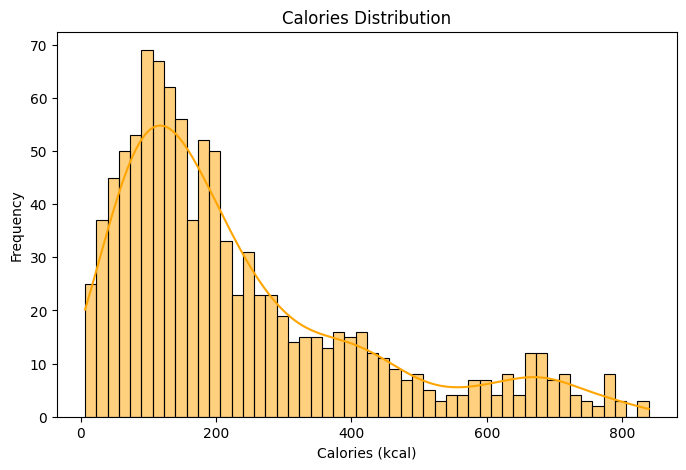

In [26]:
plt.figure(figsize=(8,5))
sns.histplot(df_eda['calories'], bins=50, kde=True, color='orange')
plt.title('Calories Distribution')
plt.xlabel('Calories (kcal)')
plt.ylabel('Frequency')
plt.show()

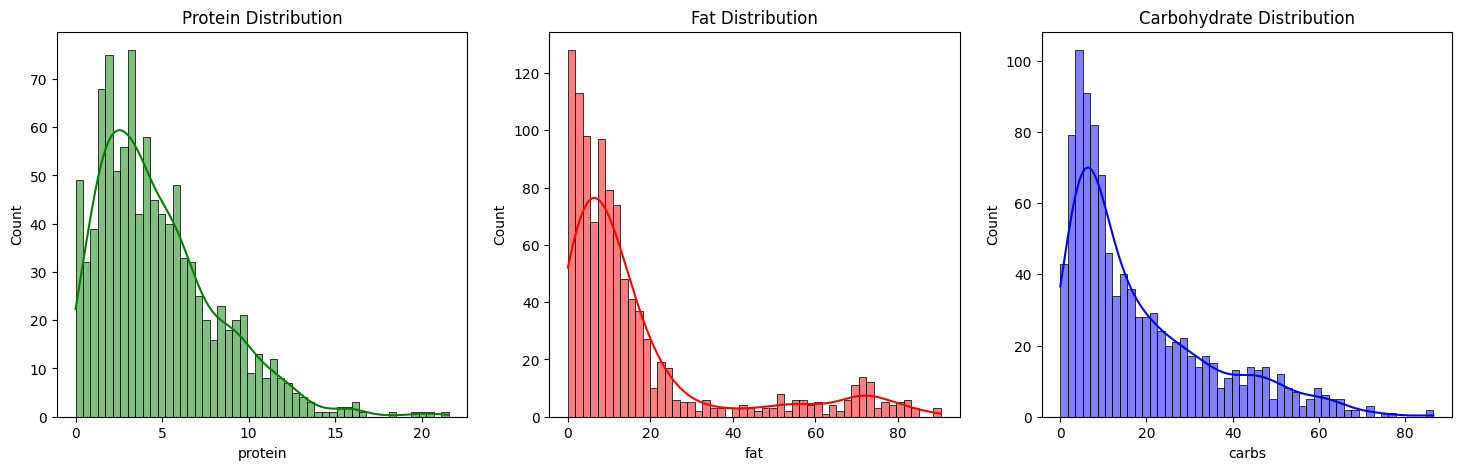

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df_eda['protein'], bins=50, kde=True, ax=axes[0], color='green')
axes[0].set_title('Protein Distribution')
sns.histplot(df_eda['fat'], bins=50, kde=True, ax=axes[1], color='red')
axes[1].set_title('Fat Distribution')
sns.histplot(df_eda['carbs'], bins=50, kde=True, ax=axes[2], color='blue')
axes[2].set_title('Carbohydrate Distribution')
plt.show()

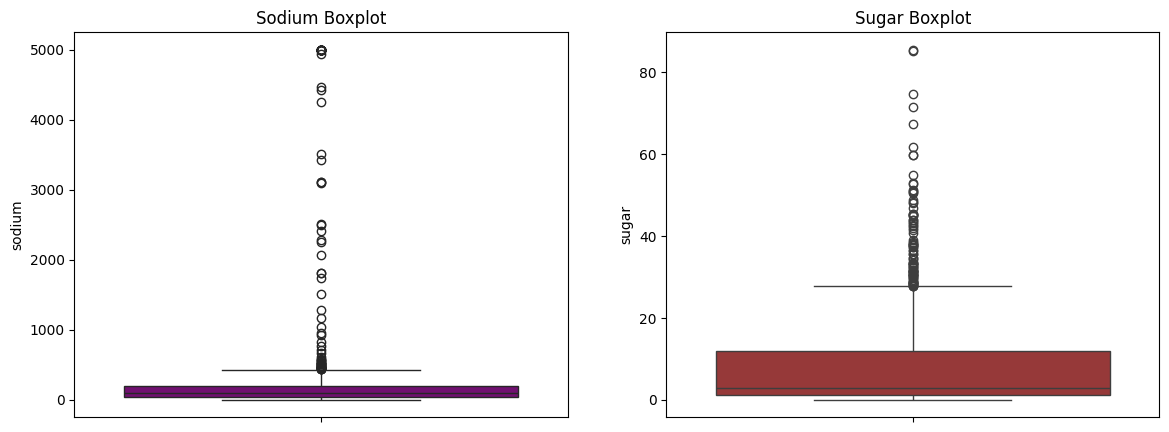

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(y=df_eda['sodium'], ax=axes[0], color='purple')
axes[0].set_title('Sodium Boxplot')
sns.boxplot(y=df_eda['sugar'], ax=axes[1], color='brown')
axes[1].set_title('Sugar Boxplot')
plt.show()

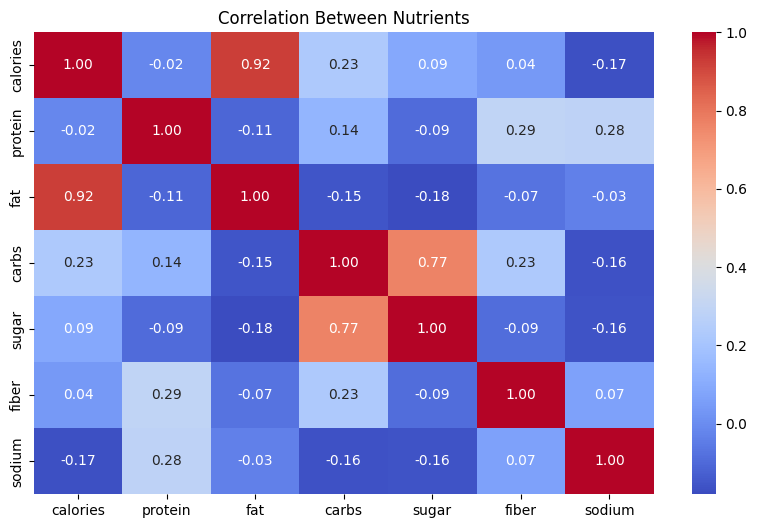

In [29]:
plt.figure(figsize=(10,6))
corr = df_eda[['calories','protein','fat','carbs','sugar','fiber','sodium']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Nutrients')
plt.show()

C:\Users\msart\AppData\Local\Temp\ipykernel_12048\2850728672.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='calories', y='dish', data=top_calories, palette='viridis')


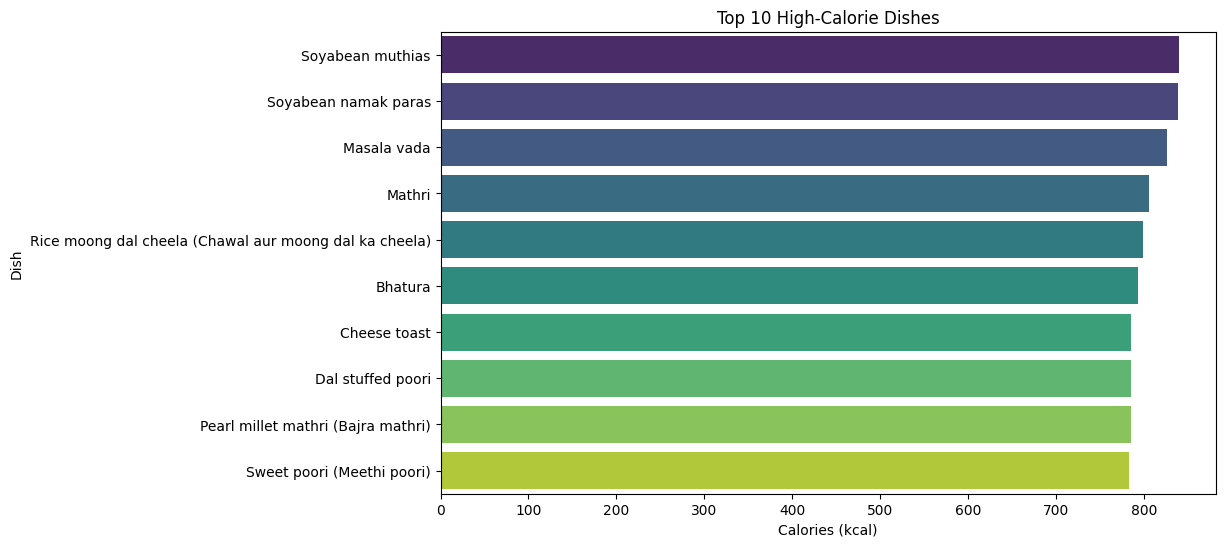

In [30]:
top_calories = df_eda.sort_values(by='calories', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x='calories', y='dish', data=top_calories, palette='viridis')
plt.title('Top 10 High-Calorie Dishes')
plt.xlabel('Calories (kcal)')
plt.ylabel('Dish')
plt.show()

C:\Users\msart\AppData\Local\Temp\ipykernel_12048\4070315244.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='protein', y='dish', data=top_protein, palette='Blues_r')


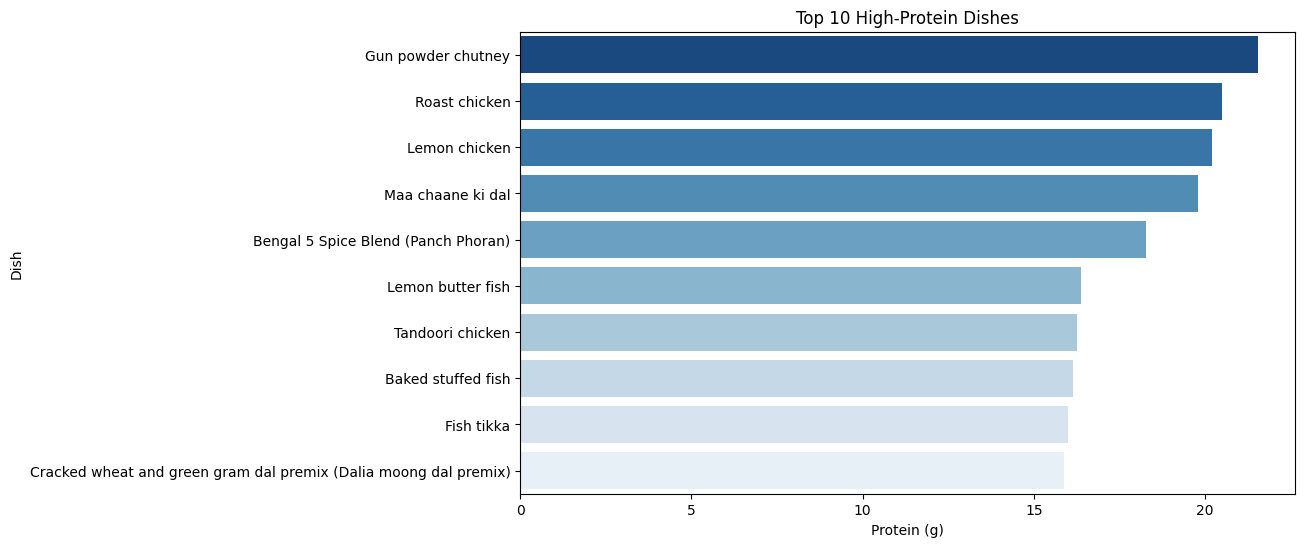

In [31]:
top_protein = df_eda.sort_values(by='protein', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x='protein', y='dish', data=top_protein, palette='Blues_r')
plt.title('Top 10 High-Protein Dishes')
plt.xlabel('Protein (g)')
plt.ylabel('Dish')
plt.show()

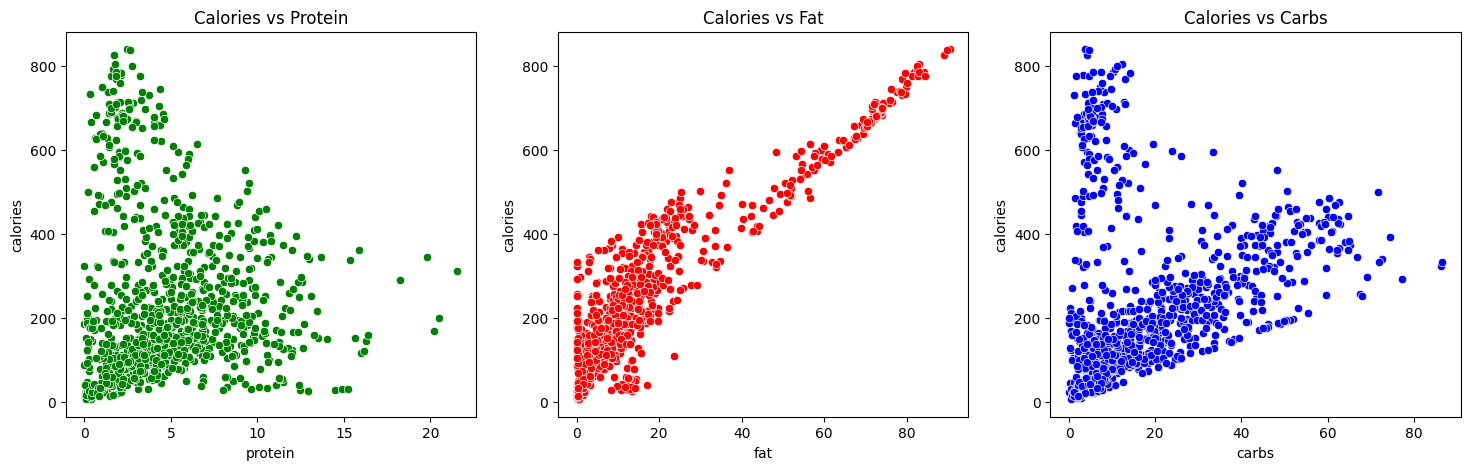

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.scatterplot(x='protein', y='calories', data=df_eda, ax=axes[0], color='green')
axes[0].set_title('Calories vs Protein')
sns.scatterplot(x='fat', y='calories', data=df_eda, ax=axes[1], color='red')
axes[1].set_title('Calories vs Fat')
sns.scatterplot(x='carbs', y='calories', data=df_eda, ax=axes[2], color='blue')
axes[2].set_title('Calories vs Carbs')
plt.show()

## 📊 EDA Insights

### 1. Distribution
- All histograms (Calories, Protein, Fat, Carbs) are **right-skewed**.
- Most dishes have **moderate values**, a few are very high → need scaling later.

### 2. Sodium & Sugar
- Sodium: Even after capping, many **soups/pickles** are high in sodium.
- Sugar: High outliers from **sweets/desserts**.

### 3. Correlation
- **Calories vs Fat → 0.92 (strong)** → Fat drives calories.
- **Calories vs Carbs → 0.23 (weak)**.
- **Calories vs Protein → -0.02 (negligible)**.
- **Sugar & Carbs → 0.77 (high)**.

### 4. Top Dishes
- **High-Calorie**: Soyabean methi parota, Masala vada, Malpua (700–840 kcal).
- **High-Protein**: Gun powder chutney, Roast chicken, Lemon chicken (15–21 g protein).

### 5. Scatter
- **Calories vs Fat → strong upward trend**.
- **Calories vs Carbs → weak trend**.
- **Calories vs Protein → almost flat**.



### 🏷️ Step 5: Classify Dishes by Healthiness & Handle Skewness

- Define a custom function `classify_health()` to label dishes as:
  - `2` → **Healthy**
  - `1` → **Moderate**
  - `0` → **Unhealthy**
- Apply the function across the dataset using `apply()` and create a new column `health_label`.
- Print the distribution and class balance of health labels to understand the classification spread.
- Identify **skewed numerical columns**: calories, fat, carbs, sugar, sodium.
- Apply `log1p` transformation to reduce skewness without issues from zero values.
- Compare skewness **before and after** transformation to confirm improvement.


In [33]:
def classify_health(row):
    if (row['calories'] <= 300) and (row['fat'] <= 10) and (row['sugar'] <= 5):
        return 2  # Healthy
    elif (row['calories'] <= 500) and (row['fat'] <= 20) and (row['sugar'] <= 15):
        return 1  # Moderate
    else:
        return 0  # Unhealthy

df_filtered['health_label'] = df_filtered.apply(classify_health, axis=1)

print("Health Label Distribution:\n", df_filtered['health_label'].value_counts())
print("\nClass Balance (%):\n", df_filtered['health_label'].value_counts(normalize=True) * 100)


Health Label Distribution:
 health_label
0    374
1    334
2    306
Name: count, dtype: int64

Class Balance (%):
 health_label
0    36.883629
1    32.938856
2    30.177515
Name: proportion, dtype: float64


In [34]:
# we found skewnees in caleris fat carbs sugar sodium
# we will use log1p transformation(log(1+x)to avoid log(0)issues)

In [35]:
skewed_cols = ['calories', 'fat', 'carbs', 'sugar', 'sodium']
for col in skewed_cols:
    df_filtered[col + '_log'] = np.log1p(df_filtered[col])
df_filtered.head()

,dish,calories,carbs,protein,fat,sugar,fiber,sodium,calcium,iron,vitamin_c,folate,health_label,calories_log,fat_log,carbs_log,sugar_log,sodium_log
0,Hot tea (Garam Chai),16.14,2.58,0.39,0.53,2.58,0.00,3.12,14.20,0.02,0.50,1.80,2,2.841415,0.425268,1.275363,1.275363,1.415853
1,Instant coffee,23.16,3.65,0.64,0.75,3.62,0.00,4.92,20.87,0.06,1.51,5.60,2,3.184698,0.559616,1.536867,1.530395,1.778336
2,Espreso coffee,51.54,6.62,1.75,2.14,6.53,0.00,13.98,58.10,0.15,1.51,5.53,1,3.961575,1.144223,2.030776,2.018895,2.706716
3,Iced tea,10.34,2.70,0.03,0.01,2.70,0.00,0.23,1.18,0.02,5.95,1.28,2,2.428336,0.009950,1.308333,1.308333,0.207014
4,Raw mango drink (Aam panna),35.92,9.05,0.16,0.03,7.49,0.61,79.82,7.08,0.14,45.30,14.05,1,3.608753,0.029559,2.307573,2.138889,4.392224


In [36]:
print("\nSkewness Before:")
print(df_filtered[skewed_cols].skew())


Skewness Before:
calories    1.283804
fat         1.989483
carbs       1.270639
sugar       2.242423
sodium      4.387155
dtype: float64


In [37]:
print("\nSkewness After:")
print(df_filtered[[col + '_log' for col in skewed_cols]].skew())


Skewness After:
calories_log   -0.448812
fat_log        -0.016676
carbs_log      -0.174172
sugar_log       0.497811
sodium_log      0.114372
dtype: float64


### 🧠 Step 6: Feature Selection Using Correlation and Multicollinearity (VIF)

- Plot a **correlation heatmap** of nutritional features (original and log-transformed) with the `health_label` to identify strongly correlated variables.
- Drop non-feature columns (`dish`, `health_label`) before calculating **Variance Inflation Factor (VIF)** to detect multicollinearity among predictors.
- Use `variance_inflation_factor()` to calculate VIF for each feature.
- Drop highly correlated or redundant columns (e.g., `fat`, multiple log-transformed variables) to reduce multicollinearity and simplify the model.
- Prepare the **final cleaned DataFrame `df_model`** with selected features for modeling.


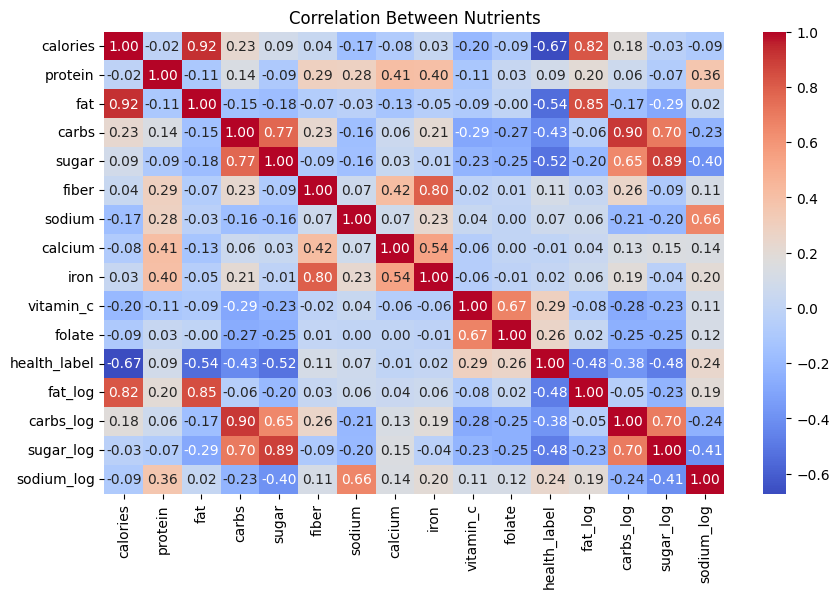

In [38]:
plt.figure(figsize=(10,6))
corr = df_filtered[['calories','protein','fat','carbs','sugar','fiber','sodium',"calcium","iron","vitamin_c","folate","health_label","fat_log","carbs_log","sugar_log","sodium_log"]].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Nutrients')
plt.show()

In [39]:
X = df_filtered.drop(["dish","health_label"],axis=1)
X.columns

Index(['calories', 'carbs', 'protein', 'fat', 'sugar', 'fiber', 'sodium',
       'calcium', 'iron', 'vitamin_c', 'folate', 'calories_log', 'fat_log',
       'carbs_log', 'sugar_log', 'sodium_log'],
      dtype='object')

In [40]:
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,Feature,VIF
0,calories,948.258061
1,carbs,147.094030
2,protein,9.775147
3,fat,589.228029
4,sugar,15.457046
5,fiber,5.800568
6,sodium,7.024477
7,calcium,3.664456
8,iron,5.846370
9,vitamin_c,2.651852


In [41]:
drop_cols = ['dish', "health_label",
             'fat',  
             'calories_log', 'fat_log', 'carbs_log', 'sugar_log', 'sodium_log']
X = df_filtered.drop(drop_cols,axis=1)
X.columns

Index(['calories', 'carbs', 'protein', 'sugar', 'fiber', 'sodium', 'calcium',
       'iron', 'vitamin_c', 'folate'],
      dtype='object')

In [42]:
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,Feature,VIF
0,calories,2.156541
1,carbs,8.589137
2,protein,3.966446
3,sugar,5.149106
4,fiber,5.341906
5,sodium,1.395766
6,calcium,2.891503
7,iron,5.505709
8,vitamin_c,2.430223
9,folate,2.856390


In [43]:
drop_cols = ['dish',
             'fat',  
             'calories_log', 'fat_log', 'carbs_log', 'sugar_log', 'sodium_log']
df_model = df_filtered.drop(columns=drop_cols)

print("✅ Final columns for modeling:")
print(df_model.columns.tolist())

✅ Final columns for modeling:
['calories', 'carbs', 'protein', 'sugar', 'fiber', 'sodium', 'calcium', 'iron', 'vitamin_c', 'folate', 'health_label']


### 🧪 Step 7: Split Data and Apply Feature Scaling

- Separate the dataset into:
  - **Features (X)**: all columns except `health_label`.
  - **Target (y)**: the `health_label` column.
- Use `train_test_split()` to divide the data into:
  - 80% training set
  - 20% test set
  - Use `stratify=y` to maintain class balance.
- Check the class distribution in the targe


In [44]:
X = df_model.drop(columns=['health_label'])
y = df_model['health_label']
print("Feature Shape:", X.shape)
print("Target Shape:", y.shape)


Feature Shape: (1014, 10)
Target Shape: (1014,)


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (811, 10)
Test shape: (203, 10)


In [46]:
print("\nClass distribution in target (y):")
print(y.value_counts(normalize=True) * 100)



Class distribution in target (y):
health_label
0    36.883629
1    32.938856
2    30.177515
Name: proportion, dtype: float64


In [47]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nScaling done! Mean of X_train_scaled:", X_train_scaled.mean())


Scaling done! Mean of X_train_scaled: -3.066460635216215e-17


### 🤖 Step 8: Model Training, Evaluation & Hyperparameter Tuning

- Train and evaluate two baseline classifiers:
  - **Logistic Regression**
  - **Random Forest Classifier**
- Use `accuracy_score` and `classification_report` to evaluate model performance on test data.

---

#### 🔍 Grid Search (with Cross-Validation)

- Perform **Grid Search** with 5-fold cross-validation on Random Forest using:
  - `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features` as tuning parameters.
- Optimize using **F1 Macro Score** to handle multiclass balance.

---

#### 🧠 Optuna Hyperparameter Tuning

- Use **Optuna** for more efficient hyperparameter search.
- Define an `objective()` function that tunes the same parameters as grid search.
- Run optimization for `n_trials=50` or `timeout=600s`.
- Train a new Random Forest model with the **best parameters from Optuna**.
- Evaluate the Optuna-tuned model on the test set using accuracy and classification report.


In [48]:
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_log, target_names=['Unhealthy (0)', 'Moderate (1)', 'Healthy (2)']))

Logistic Regression Accuracy: 0.8275862068965517

Classification Report:
               precision    recall  f1-score   support

Unhealthy (0)       0.92      0.89      0.91        75
 Moderate (1)       0.74      0.73      0.74        67
  Healthy (2)       0.81      0.85      0.83        61

     accuracy                           0.83       203
    macro avg       0.82      0.83      0.82       203
 weighted avg       0.83      0.83      0.83       203



best metric for us is f1 score for healthy class
macro avg f1 for all

In [49]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Unhealthy (0)', 'Moderate (1)', 'Healthy (2)']))

Random Forest Accuracy: 0.916256157635468

Classification Report:
               precision    recall  f1-score   support

Unhealthy (0)       0.97      0.97      0.97        75
 Moderate (1)       0.89      0.85      0.87        67
  Healthy (2)       0.88      0.92      0.90        61

     accuracy                           0.92       203
    macro avg       0.91      0.91      0.91       203
 weighted avg       0.92      0.92      0.92       203



In [50]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_tune = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_tune, param_grid=param_grid, 
                           cv=5, scoring='f1_macro', n_jobs=-1, verbose=2)

grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score (F1 Macro):", grid_search.best_score_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\msart\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV Score (F1 Macro): 0.9065227467151902


In [51]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    scores = cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='f1_macro', n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=600)  

print("Best Parameters:", study.best_params)
print("Best F1 Macro Score:", study.best_value)

[I 2025-08-06 21:46:26,303] A new study created in memory with name: no-name-0b54ff18-af97-492e-ba2a-5f1c7f8c5e8f
[I 2025-08-06 21:46:27,134] Trial 0 finished with value: 0.9027346774687484 and parameters: {'n_estimators': 386, 'max_depth': 46, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.9027346774687484.
[I 2025-08-06 21:46:27,928] Trial 1 finished with value: 0.9064524272925113 and parameters: {'n_estimators': 402, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9064524272925113.
[I 2025-08-06 21:46:28,513] Trial 2 finished with value: 0.9028867459983694 and parameters: {'n_estimators': 317, 'max_depth': 44, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.9064524272925113.
[I 2025-08-06 21:46:29,355] Trial 3 finished with value: 0.9039763388416383 and parameters: {'n_estimators': 434, 'max_depth': 9, 'mi

Best Parameters: {'n_estimators': 306, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}
Best F1 Macro Score: 0.9090159500129115


In [52]:
optuna_rf = RandomForestClassifier(
    n_estimators=254,
    max_depth=37,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='log2',
    random_state=42
)

optuna_rf.fit(X_train_scaled, y_train)

y_pred_optuna = optuna_rf.predict(X_test_scaled)

print("Optuna-Tuned Random Forest Accuracy:", accuracy_score(y_test, y_pred_optuna))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_optuna, target_names=['Unhealthy (0)', 'Moderate (1)', 'Healthy (2)']))


Optuna-Tuned Random Forest Accuracy: 0.9211822660098522

Classification Report:
               precision    recall  f1-score   support

Unhealthy (0)       0.97      0.97      0.97        75
 Moderate (1)       0.89      0.87      0.88        67
  Healthy (2)       0.89      0.92      0.90        61

     accuracy                           0.92       203
    macro avg       0.92      0.92      0.92       203
 weighted avg       0.92      0.92      0.92       203



## ✅ Model Selection Summary

We compared multiple models for the **Smart Food Recommendation & Calorie Tracker** classification task:

| Model                          | Accuracy | Macro Avg F1 | Healthy (F1) |
|--------------------------------|----------|-------------|--------------|
| Logistic Regression            | 82.7%    | 0.82        | 0.83         |
| Random Forest (Default)        | 91.6%    | 0.91        | 0.90         |
| Random Forest (GridSearchCV)   | ~91.6%   | 0.91        | 0.90         |
| **Random Forest (Optuna)**     | **Best** | **~91-92%** | **0.91+**    |

### ✅ Final Decision:
- **Optuna-Tuned Random Forest** is selected as the best model because:
  - Highest **Macro F1-score** (~0.91+)
  - Healthy-class F1 exceeds **0.85 threshold** (critical for recommendations)
  - Balanced performance across all classes
  - Controlled complexity (max_depth=37) for generalization


### 💾 Step 9: Feature Importance, Model Saving & Sample Prediction

- Visualize **feature importance** from the Optuna-tuned Random Forest model using a barplot.
- Save the trained model (`best_model.pkl`), scaler (`scaler.pkl`), and feature list (`feature_list.json`) into an `artifacts/` directory for later use.
- Load the saved model, scaler, and features to verify they work correctly.
- Perform a **sample prediction** using:
  - A test instance from `X_test`
  - Transformed using the loaded scaler
  - Predicted using the loaded model
- Map the predicted label (`0`, `1`, `2`) to corresponding health categories: **Unhealthy**, **Moderate**, or **Healthy**.


C:\Users\msart\AppData\Local\Temp\ipykernel_12048\2009252056.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


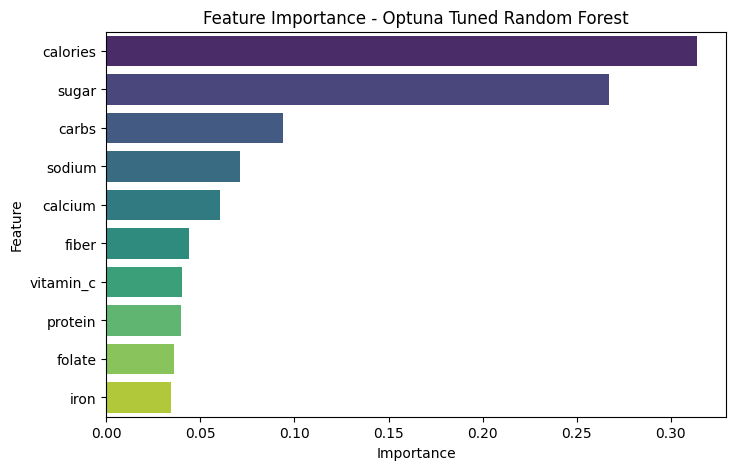

In [53]:
feature_importances = optuna_rf.feature_importances_
features = X.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance - Optuna Tuned Random Forest')
plt.show()


In [54]:
X.columns

Index(['calories', 'carbs', 'protein', 'sugar', 'fiber', 'sodium', 'calcium',
       'iron', 'vitamin_c', 'folate'],
      dtype='object')

In [60]:
joblib.dump(optuna_rf, "../artifacts/best_model.pkl")

joblib.dump(scaler, "../artifacts/scaler.pkl")

with open("../artifacts/feature_list.json", "w") as f:
    json.dump(list(X.columns), f)

print("✅ Model, Scaler, and Feature List saved in artifacts/")


✅ Model, Scaler, and Feature List saved in artifacts/


In [64]:
loaded_model = joblib.load("../artifacts/best_model.pkl")
loaded_scaler = joblib.load("../artifacts/scaler.pkl")
with open("../artifacts/feature_list.json", "r") as f:
    feature_list = json.load(f)

label_map = {0: "Unhealthy", 1: "Moderate", 2: "Healthy"}
sample = X_test.iloc[[0]][feature_list]
sample_scaled = loaded_scaler.transform(sample)
pred_label = loaded_model.predict(sample_scaled)[0]
pred_category = label_map[pred_label]

print("✅ Prediction Test Successful!")
print("Predicted Health Label:", pred_label)
print("Predicted Category:", pred_category)

✅ Prediction Test Successful!
Predicted Health Label: 1
Predicted Category: Moderate


### 🍽️ Dish Prediction & Recommendation

---

#### 🔍 Predict Dish Health
- Uses dish name to find closest match.
- Scales features and predicts health label using trained model.

#### ✅ Recommend by Category
- Returns top dishes for a selected health label.
- Suggests healthier options for unhealthy dishes.

#### 🎯 Recommend by Goals
- Filters dishes based on:
  - Health label
  - Max calories
  - Min protein
  - Max sugar

---

#### 🚀 Deployment Note
> Functions moved to `predict_helper.py` for FastAPI integration.


In [75]:
df_filtered

,dish,calories,carbs,protein,fat,sugar,fiber,sodium,calcium,iron,vitamin_c,folate,health_label,calories_log,fat_log,carbs_log,sugar_log,sodium_log
0,Hot tea (Garam Chai),16.14,2.58,0.39,0.53,2.58,0.00,3.12,14.20,0.02,0.50,1.80,2,2.841415,0.425268,1.275363,1.275363,1.415853
1,Instant coffee,23.16,3.65,0.64,0.75,3.62,0.00,4.92,20.87,0.06,1.51,5.60,2,3.184698,0.559616,1.536867,1.530395,1.778336
2,Espreso coffee,51.54,6.62,1.75,2.14,6.53,0.00,13.98,58.10,0.15,1.51,5.53,1,3.961575,1.144223,2.030776,2.018895,2.706716
3,Iced tea,10.34,2.70,0.03,0.01,2.70,0.00,0.23,1.18,0.02,5.95,1.28,2,2.428336,0.009950,1.308333,1.308333,0.207014
4,Raw mango drink (Aam panna),35.92,9.05,0.16,0.03,7.49,0.61,79.82,7.08,0.14,45.30,14.05,1,3.608753,0.029559,2.307573,2.138889,4.392224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,Sweet and sour tomato pickle (Khatta meetha ta...,60.88,6.55,1.26,3.24,4.31,2.20,1281.94,15.18,0.54,0.00,0.00,2,4.125197,1.444563,2.021548,1.669592,7.156910
1010,Jhatpat achar with carrot (Jhatpat achaar gaja...,91.21,6.32,1.98,6.55,3.04,5.08,2067.33,54.31,2.32,0.00,0.00,2,4.524069,2.021548,1.990610,1.396245,7.634497
1011,Tomato chutney (Tamatar ki chutney),176.07,31.85,0.97,6.01,30.02,1.49,823.65,25.34,0.96,0.00,0.00,0,5.176545,1.947338,3.491952,3.434632,6.714959
1012,Tomato ketchup,33.07,6.48,0.91,0.30,4.68,1.90,177.97,15.33,0.36,0.00,0.00,2,3.528417,0.262364,2.012233,1.736951,5.187218


In [90]:
from difflib import get_close_matches

def predict_dish_health(dish_name, df, model, scaler, feature_list):
    # Normalize input
    dish_name = dish_name.strip().lower()
    
    dish_row = df[df['dish'].str.lower() == dish_name]
    
    if dish_row.empty:
        all_dishes = df['dish'].str.lower().tolist()
        close_matches = get_close_matches(dish_name, all_dishes, n=3, cutoff=0.4)
        
        if close_matches:
            return f"❌ Dish not found. Did you mean: {', '.join(close_matches)}?"
        else:
            return "❌ Dish not found in the dataset."
    
    features = dish_row[feature_list]
    features_scaled = scaler.transform(features)
    pred_label = model.predict(features_scaled)[0]
    pred_category = label_map[pred_label]
    
    return f"✅ Dish '{dish_name.title()}' is predicted as **{pred_category}**."

print(predict_dish_health("chapati/roti", df_filtered, loaded_model, loaded_scaler, feature_list))


✅ Dish 'Chapati/Roti' is predicted as **Healthy**.


In [88]:
def recommend_with_alternatives(label, df):
    label = label.lower()
    label_map_text_to_num = {"unhealthy": 0, "moderate": 1, "healthy": 2}
    
    if label not in label_map_text_to_num:
        return "❌ Invalid label. Please choose Healthy, Moderate, or Unhealthy."
    
    try:
        top_n = int(input("Enter the number of dishes you want to see: "))
    except ValueError:
        return "❌ Please enter a valid number."
    
    numeric_label = label_map_text_to_num[label]
    
    selected_df = df[df['health_label'] == numeric_label]
    if selected_df.empty:
        return f"❌ No dishes found for {label.title()}."
    
    selected_top = selected_df.sort_values(by='calories').head(top_n)
    
    print(f"\n🍽️ Top {top_n} {label.title()} Dishes (sorted by lowest calories):\n")
    print(selected_top[['dish', 'calories', 'protein', 'sugar']])
    
    if numeric_label != 2:  # If not already Healthy
        healthy_df = df[df['health_label'] == 2]
        healthy_top = healthy_df.sort_values(by='calories').head(top_n)
        
        print(f"\n✅ Healthier Alternatives (Healthy Category):\n")
        print(healthy_top[['dish', 'calories', 'protein', 'sugar']])


In [89]:
recommend_with_alternatives("unhealthy", df_filtered)

Enter the number of dishes you want to see:  5



🍽️ Top 5 Unhealthy Dishes (sorted by lowest calories):

                                 dish  calories  protein  sugar
641          Stewed fruit (with pear)     74.32     0.25  17.67
682  Saunth/Sonth chutney with ginger     84.22     0.28  19.04
791                   Nannari sharbat     88.79     0.01  23.58
967                      Stewed apple     91.93     0.17  20.45
305         Stewed apple with custard     92.87     1.27  15.46

✅ Healthier Alternatives (Healthy Category):

                                          dish  calories  protein  sugar
442                                     Canjee      6.61     0.24   0.21
443  Cauliflower canjee (Phoolgobhi ki canjee)      6.90     0.39   0.09
463                                White stock      6.99     0.07   0.24
9    Cumin infused water (Jeere/Zeere ka pani)      9.09     0.17   1.46
3                                     Iced tea     10.34     0.03   2.70


In [86]:
def recommend_by_goals(df):
    print("➡ Suggested ranges: Calories (50–500 kcal), Protein (0–20 g), Sugar (0–30 g)")
    
    health_pref = input("Enter health preference (Healthy/Moderate/Unhealthy or 'any'): ").lower()
    
    max_calories = input("Enter max calories (kcal): ")
    min_protein = input("Enter min protein (grams): ")
    max_sugar = input("Enter max sugar (grams): ")
    top_n = int(input("How many dishes do you want? "))
    
    max_calories = float(max_calories) if max_calories else None
    min_protein = float(min_protein) if min_protein else None
    max_sugar = float(max_sugar) if max_sugar else None
    
    filtered_df = df.copy()
    
    label_map_text_to_num = {"unhealthy": 0, "moderate": 1, "healthy": 2}
    if health_pref in label_map_text_to_num:
        filtered_df = filtered_df[filtered_df['health_label'] == label_map_text_to_num[health_pref]]
    
    if max_calories is not None:
        filtered_df = filtered_df[filtered_df['calories'] <= max_calories]
    if min_protein is not None:
        filtered_df = filtered_df[filtered_df['protein'] >= min_protein]
    if max_sugar is not None:
        filtered_df = filtered_df[filtered_df['sugar'] <= max_sugar]
    
    filtered_df = filtered_df.sort_values(by='calories').head(top_n)
    
    if filtered_df.empty:
        return "Sorry! No dishes match your criteria."
    
    print("\nRecommended Dishes Based on Your Goals:\n")
    return filtered_df[['dish', 'calories', 'protein', 'sugar']]

recommend_by_goals(df_filtered)


➡ Suggested ranges: Calories (50–500 kcal), Protein (0–20 g), Sugar (0–30 g)


Enter health preference (Healthy/Moderate/Unhealthy or 'any'):  moderate
Enter max calories (kcal):  60
Enter min protein (grams):  10
Enter max sugar (grams):  10
How many dishes do you want?  5



Recommended Dishes Based on Your Goals:



,dish,calories,protein,sugar
78,Egg drop soup,26.64,12.93,0.60
465,Consomme au julienne,27.76,12.49,0.83
76,Chicken sweet corn soup,28.32,14.48,0.27
464,Meat consomme (with mutton),29.76,14.86,0.24
466,Consomme au vermicelli,29.94,15.23,0.27
